In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy.stats import norm, chi2

import slam.motion_models.odometry_model as odom
from slam.data import read_simple_world, read_simple_data
from slam.utils import normalize_angle
from slam.robot import BaseRobot
from slam.map import LandmarkMap
from slam.ekf_slam import EKFSLAMKnown

In [3]:
def cov_ellipse(cov, q=None, nsig=None, **kwargs):
    """
    Parameters
    ----------
    cov : (2, 2) array
        Covariance matrix.
    q : float, optional
        Confidence level, should be in (0, 1)
    nsig : int, optional
        Confidence level in unit of standard deviations. 
        E.g. 1 stands for 68.3% and 2 stands for 95.4%.

    Returns
    -------
    width, height, rotation :
         The lengths of two axises and the rotation angle in degree
    for the ellipse.
    """

    if q is not None:
        q = np.asarray(q)
    elif nsig is not None:
        q = 2 * norm.cdf(nsig) - 1
    else:
        raise ValueError('One of `q` and `nsig` should be specified.')
    r2 = chi2.ppf(q, 2)

    val, vec = np.linalg.eigh(cov)
    width, height = 2 * np.sqrt(val[:, None] * r2)
    rotation = np.degrees(np.arctan2(*vec[::-1, 0]))

    return width, height, rotation

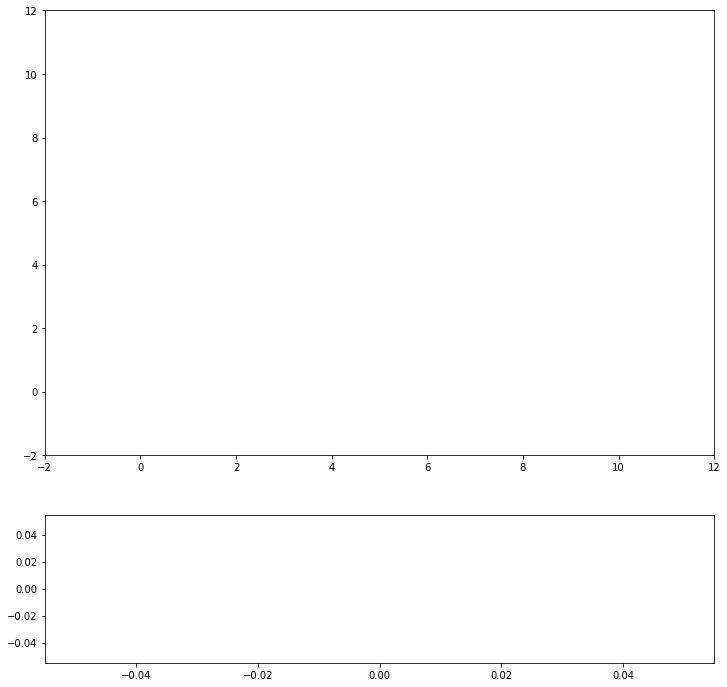

In [4]:
robot = BaseRobot(0, 0, 0, odom.odometry_command)

odometry, sensor = read_simple_data('../data/simple/sensor_data.dat')
landmarks = read_simple_world('../data/simple/world.dat')

landmark_map = LandmarkMap([])
true_map = LandmarkMap(landmarks)
commands = [np.array(odom).T for odom in odometry]

num_landmarks = len(landmarks)
EKF = EKFSLAMKnown(robot.pose, num_landmarks, odom.odometry_command)

# Plot true robot path
x = []
y = []
EKF_x = []
EKF_y = []
gtlx = []
gtly = []
cov_dets = []
ellipses = []

fig, (ax, ax1) = plt.subplots(2, 1, 
                              figsize=(12, 12), 
                              gridspec_kw={'height_ratios':[3, 1]})
ax.set_xlim((-2, 12))
ax.set_ylim((-2, 12))

ln, = ax.plot([], [], 'g', zorder=2)
pn, = ax.plot([], [], 'bx', markersize=5, zorder=3)
lm, = ax.plot([], [], 'ro', zorder=2)
gtlm, = ax.plot([], [], 'ko', zorder=2)
sline, = ax.plot([], [], 'k')
det_line, = ax1.plot([], [])
    
def init():
    ln.set_data([], [])
    sline.set_data([], [])
    det_line.set_data([], [])
    return ln, pn, sline, det_line,

counter = 0
def update(frame):
    global counter
    global ellipses
    
    for e in ellipses:
        e.remove()
    ellipses = []
    
    command, readings = frame
    
    # True path
    robot.motion_command(command)
    x.append(robot.pose.item(0))
    y.append(robot.pose.item(1))
    
    EKF.predict(command)
    
    rx = EKF.mean.item(0)
    ry = EKF.mean.item(1)
    rtheta = normalize_angle(EKF.mean.item(2))
    
    line_x = []
    line_y = []
    
    for reading in readings:
        lid, srange, sbearing = reading
        
        ang = normalize_angle(sbearing + rtheta)
        olx = rx + srange * math.cos(ang)
        oly = ry + srange * math.sin(ang)
        
        line_x.append([rx, olx])
        line_y.append([ry, oly])
    
    EKF.correct(readings, landmark_map)
    
    EKF_x.append(EKF.mean.item(0))
    EKF_y.append(EKF.mean.item(1))
    
    lm_x = []
    lm_y = []
    for key, value in landmark_map.landmarks.items():
        lx, ly = EKF.get_landmark(key)
        tlx, tly = true_map.get(key)
        lm_x.append(lx)
        lm_y.append(ly)
        #Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

        lid = EKF.get_mu_lid(key)
        lm_cov = EKF.cov[lid:lid+EKF.lmsize, lid:lid+EKF.lmsize]

        width, height, angle = cov_ellipse(lm_cov, nsig=2)
        el = Ellipse(xy=(lx, ly), width=width, height=height, angle=angle)
        ellipses.append(el)
        
        gtlx.append(tlx)
        gtly.append(tly)
        
    if counter % 10 == 0:
        for e in ellipses:
            ax.add_artist(e)
        counter = 0
    else:
        counter = counter + 1
    
    cov_det = np.linalg.det(EKF.cov[:EKF.rsize, :EKF.rsize])
    cov_dets.append(cov_det)
        
    cr = range(0, len(cov_dets))
    det_line.set_data(cr, cov_dets)
    ax1.set_xlim((0, len(cov_dets)))
    ax1.set_ylim((0, max(cov_dets)*1.1))
    
    ln.set_data(x, y)
    lm.set_data(lm_x, lm_y)
    gtlm.set_data(gtlx, gtly)
    pn.set_data(EKF_x, EKF_y)
    sline.set_data(line_x, line_y)
    
    return ln, pn, lm, sline, det_line,

ani = FuncAnimation(fig, update, frames=zip(commands, sensor), init_func=init, blit=True, interval=200)

In [5]:
HTML(ani.to_html5_video())

RuntimeError: Requested MovieWriter (ffmpeg) not available